## 18.3 Time-dependent, super-critical excursion

A burst reactor is constructed by building a sphere of plutonium-239 that has a cylindrical hole inside which a slug of plutonium can be inserted.  You will model this reactor as a solid sphere with a radius of 7 cm when the slug is in the reactor and as a hollow shell with the same outer radius and an inner radius of 2 cm when the slug is not present.  For the plutonium use the following cross-sections from the report $\it{Reactor~Physics~Constants}$, ANL-5800:

For the density of plutonium use $19.74$ g/cm$^3$; the diffusion coefficient is $D = 1/3\Sigma_\mathrm{tr}$. In the hollow area of the shell, use $\Sigma_a = \nu\Sigma_\mathrm{f} = 0$ and $D = 100$ cm. The average neutron speed in this problem is $v = 10^4$ cm/s.

$\br$An experiment is performed where there is initially 1000 neutrons uniformly distributed in the system at time $t=0$ when the solid sphere is assembled.  The sphere is solid until $t = 0.1$s at which time you can assume reactor is the hollow shell. 

$\br$Your task is to compute the total number of neutrons that leak out of the sphere from time $t=0$ to $t=5$s as well as the peak fission rate density in the reactor during the experiment.  Finally, determine  the maximum value of 

$$\frac{d}{dt} \ln \phi(r) \approx \frac{\ln\phi^{n+1}(r)  - \ln \phi^n(r)}{\Delta t}.$$

$\br$Note: The leakage rate from the sphere per unit surface area is is

$$\left.-D\frac{d\phi}{dr}\right|_{r=7.0},$$

and the fission rate density at any point in the system is $\Sigma_\mathrm{f}(r)\, \phi(r).$

## Solution

The system above will have two states. The first exists on the time interval $t = [0,0.1)$, and the second on $t = [0.1,5.0]$. We will define functions that contain the material properties for both of these intervals. 

$\br$The $\texttt{DiffusionSolver}$ function from the Chapter 18 notes will be utilized, and is stored in the file $\texttt{ch18.py}$. The solver will be executed using 100 cells and a timestep of 0.01 sec.

$\br$In order to solve the time-dependent problem, a $\texttt{for}$ loop will be used to solve the diffusion equation at each time step. The original neutron distrubtion will be reprsented as a source as such

$$\phi^0(r) = \frac{Nv}{\frac{4}{3} \pi R^3},$$

where $N$ is the number of neutrons, and $R$ is the outer radius of the sphere. This distrubtion is set into an array that is the size of the number of cells in the mesh. 

$\br$We must also define a new absorption cross-section and source as

$$\Sigma_\mathrm{a}^* = \Sigma_a(r) + \frac{1}{v \Delta t},~~~~~Q^{n+1,*}(r) = Q^{n+1}(r) + \frac{1}{v \Delta t}\phi^n(r).$$

$\br$Within each time step, the running time is used to determine the state of the system. In this case, if $t < 0.1$ sec, we will use the material properties for the solid sphere. Otherwise, we will use the material properties for the hollow sphere. The boundary condition is then set to the previous value of $\phi$ at the right boundary. At the end of each iteration, the new values of $\phi$ are stored such that they can be used for the next iteration.

$\br$Variables are created that will store the total leakage, the maximum fission rate density, and the maximum value of $\frac{d}{dt} \mathrm{ln}~\phi(r)$. The value of the scalar flux at the edge of the sphere for the purpose of the leakage rate can be approximated using a backward difference as

$$\left.-D\frac{d\phi}{dr}\right|_{r=R} = \frac{\phi_I - \phi_{I-1}}{dr}.$$

Once this value is known, it is multiplied through by the diffusion coefficient and the surface area of the outer sphere. Within each time step, all of the above properties are evaluated and compared to the defined maximums. If larger, the maximums are then set to the new value.
$\br$

In [2]:
# NUEN 329
# Time-dependent, super-critical excursion

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Functions from chapter 18
from ch18 import *

# Define cool numbers
Na = 6.022E23 # [atoms/mol]

# Define position related constants 
R = 7.0 # [cm]
Rh = 2.0 # [cm]
SAR = 4*np.pi*R**2 # surface area at R [cm^2]
I = 100 # number of cells
dr = R/I # width of a cell

# Define time related constants
tHollow = 0.1 # [sec]
tFinal = 5.0 # [sec]
dt = 0.01 # [sec]
times = np.linspace(dt,tFinal,tFinal/dt)

# Define plutonium constants
sigf239 = 1.85E-24 # [cm^2]
siga239 = 2.11E-24 # [cm^2]
sigtr239 = 6.8E-24 # [cm^2]
nu239 = 2.98 # [n/fiss]
rho239 = 19.74 # [g/cm^3]
m239 = 239.05429 # [g]

# Convert plutonium cross sections
N239 = Na*rho239/m239 # [atoms/cm^3]
Sigf239 = N239*sigf239 # [1/cm]
Siga239 = N239*siga239 # [1/cm]
Sigtr239 = N239*sigtr239 # [1/cm]
nuSigf239 = N239*nu239*sigf239 # [1/cm]
D239 = 1/(3*Sigtr239) # [cm]

# Define void (hollow) constants
Sigfvoid = 0.0
Sigavoid = 0.0
nuSigfvoid = 0.0
Dvoid = 100.0 # [cm]

# Lambda functions for solid
DSolid = lambda r: D239
SigaSolid = lambda r: Siga239
SigastarSolid = lambda r: SigaSolid(r) + 1/(v*dt)
SigfSolid = lambda r: Sigf239
nuSigfSolid = lambda r: nuSigf239

# Lambda functions for hollow
DHollow = lambda r: (r<Rh)*Dvoid + (r>=Rh)*D239
SigaHollow = lambda r: (r<Rh)*Sigavoid + (r>=Rh)*Siga239
SigastarHollow = lambda r: SigaHollow(r) + 1/(v*dt)
SigfHollow = lambda r: (r>=Rh)*Sigf239
nuSigfHollow = lambda r: (r<Rh)*nuSigfvoid + (r>=Rh)*nuSigf239

# Initial neutron distribution
neutrons = 1000
v = 10.0**4 # [cm/s]
density = neutrons/(4/3*np.pi*R**3) # [n/cm^3]
phi_old = np.ones(I)*density*v # [n/cm^2-s]

# Note steps to plot
plotSteps = np.array([0,20,100,200,400,450,499])

# Blank arrays for storing
maxFRD = 0.0
maxdphi = 0.0
leakage = 0.0

# Loop through timesteps
for t in times:
    # Solid sphere properties
    if t < tHollow:
        D = DSolid
        Siga = SigaSolid
        Sigastar = SigastarSolid
        Sigf = SigfSolid
        nuSigf = nuSigfSolid
        
    # Hollow sphere properties
    else:
        D = DHollow
        Siga = SigaHollow
        Sigastar = SigastarHollow
        Sigf = SigfSolid
        nuSigf = nuSigfHollow
    
    # Set boundary condition
    BC = phi_old[-1]
    
    # Define previous timestep source
    Qstar = lambda r: phi_old[int(np.round((r-0.5*dr)/dr-1))]/(v*dt)
    
    # Solve diffusion equation
    r, phi = DiffusionSolver(R,I,D,Sigastar,nuSigf,Qstar,BC,2)
            
    # Add to leakage
    leakage += -D(R)*(phi[-1]-phi[-2])*dt*SAR/dr
    
    # Check for max fission rate density
    for cell in range(I):
        FRD = Sigf(r[cell])*phi[cell]
        if FRD > maxFRD:
            maxFRD = FRD
    
    # Check for max change over timestep
    dphi = (np.log(phi) - np.log(phi_old))/dt
    if np.max(dphi) > maxdphi:
        maxdphi = np.max(dphi)
            
    # Carry phi to next timestep
    phi_old = phi.copy()

print('Leakage:',leakage,'neutrons')
print('Maximum fission rate density:',maxFRD,'fiss/cm^3-s')
print('Maxumum of d(ln(phi))/dt:',maxdphi,'n/cm^2-s^2')

Leakage: 712959455524955.1 neutrons
Maximum fission rate density: 2125438908647.0698 fiss/cm^3-s
Maxumum of d(ln(phi))/dt: 222.03861342648102 n/cm^2-s^2


## 19.2 Spherical Plutonium k-eigenvalue
For the burst reactor made of plutonium in the defined in the super-critical excursion problem of Chapter 18, compute the value of $k_\mathrm{eff}$ with and without the plug inserted.

## Solution

Luckily, we already have the material properties defined from the "Time-dependent, super-critical excursion" problem in Chapter 18. We'll copy those and use them here.

$\br$The file $\texttt{ch19.py}$ contains all of the functions from Chapter 19, including the $\texttt{DiffusionEigenvalue}$ function that we will use here.

$\br$After defining the necessary constants and the function, we will determine the values of $k$ for each state by running the function.

In [4]:
import numpy as np

# Functions from chapter 19
from ch19 import *

# Define cool numbers
Na = 6.022E23 # [atoms/mol]

# Define position related constants 
R = 7.0 # [cm]
Rh = 2.0 # [cm]
I = 100
dr = R/I

# Define plutonium constants
sigf239 = 1.85E-24 # [cm^2]
siga239 = 2.11E-24 # [cm^2]
sigtr239 = 6.8E-24 # [cm^2]
nu239 = 2.98 # [n/fiss]
rho239 = 19.74 # [g/cm^3]
m239 = 239.05429 # [g/mol]

# Convert plutonium cross sections
N239 = Na*rho239/m239 # [atoms/cm^3]
Sigf239 = N239*sigf239 # [1/cm]
Siga239 = N239*siga239 # [1/cm]
Sigtr239 = N239*sigtr239 # [1/cm]
nuSigf239 = N239*nu239*sigf239 # [1/cm]
D239 = 1/(3*Sigtr239) # [cm]

# Define void (hollow) constants
Sigfvoid = 0.0
Sigavoid = 0.0
nuSigfvoid = 0.0
Dvoid = 100.0 # [cm]

# Lambda functions for solid
DSolid = lambda r: D239
SigaSolid = lambda r: Siga239
SigfSolid = lambda r: Sigf239
nuSigfSolid = lambda r: nuSigf239

# Lambda functions for hollow
DHollow = lambda r: (r<Rh)*Dvoid + (r>=Rh)*D239
SigaHollow = lambda r: (r<Rh)*Sigavoid + (r>=Rh)*Siga239
SigfHollow = lambda r: (r>=Rh)*Sigf239
nuSigfHollow = lambda r: (r<Rh)*nuSigfvoid + (r>=Rh)*nuSigf239

# Calculate for solid
kSolid,phiSolid,r = DiffusionEigenvalue(R,I,DSolid,SigaSolid,nuSigfSolid,2)

# Calculate for hollow
kHollow,phiHollow,r = DiffusionEigenvalue(R,I,DHollow,SigaHollow,nuSigfHollow,2)

# And print
print('The value for keff with the plug is',kSolid)
print('The value for keff without the plug is',kHollow)

The value for keff with the plug is 0.9033667482664482
The value for keff without the plug is 0.8321149256305226


## 20.2 2-group Heterogeneous Reactor Multiplication Factor}

Consider the following 1-D cylindrical core consisting of 10 fuel regions + 1 reflector region (each region is of width 20 cm, total domain size is $R = 200$ cm).

In this  table,  R= reflector, U = UO$_2$, M = MOX, U$_\mathrm{rodded}$ = UO$_2$ + absorber. In this reactor we assume that our groups are set up so that only down scattering can be considered and all fission neutrons are born fast.

$\br$Write a python code to solve this problem. Plot the solution for $\phi(r)$ for each group and comment on the behavior. Also give the value of the multiplication factor for this reactor. For this reactor give the ratio of the peak scalar flux to the average scalar flux: this ratio is called the power peaking factor.

$\br$Then, consider the same reactor where the control rods are removed and the R region becomes a U region.  Discuss the change in the eigenvalue and the shape of the flux. 

$\br$The data you will need is below:

## Solution

We will start by defining all of the material properties given above. Here, we will do this by the way of multiple dictionaries. Once these are defined, the variable $\texttt{regions}$ will contain the order of the material regions. The property functions will then use the NumPy $\texttt{floor}$ function to round down to the nearest integer of $\frac{r}{w}$, which will be the corresponding index of the material type in the $\texttt{regions}$ variable, and can be used to call the necessary material property without a lot of code. Note that in the $\texttt{regions}$ variable, the last region is repeated twice. This is needed to allow the function to work correctly, and still allows the material functions to return the correct property.

$\br$Once the materials are defined as needed, the $\texttt{TwoGroupDiffusionEigenvalue}$ function is ran with the necessary inputs. Note that all of the functions from the Chapter 20 lecture notes are contained in $\texttt{ch20.py}$, and are imported as such.

$\br$Lastly, the power peaking factor is determined as the maximum overall flux divided by the average overall flux.$\br$

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Functions from chapter 20
from ch20 import *

# Define given data
D = {"U": {1: 1.2, 2: 0.4},
     "M": {1: 1.2, 2: 0.4},
     "R": {1: 1.2, 2: 0.2},
     "Ur": {1: 1.2, 2: 0.4}}
Sig_r = {"U": {1: 0.029653979, 2: 0.093079585},
         "M": {1: 0.029653979, 2: 0.23633218},
         "R": {1: 0.051, 2: 0.04},
         "Ur": {1: 0.029820069, 2: 0.098477509}}
v_Sig_f = {"U": {1: 0.004567474, 2: 0.114186862},
           "M": {1: 0.006851211, 2: 0.351903125},
           "R": {1: 0.0, 2: 0.0},
           "Ur": {1: 0.004567474, 2: 0.114186862}}
Sig_ds = {"U": 0.020432526,
          "M": 0.015865052,
          "R": 0.05,
          "Ur": 0.02032872}

# Define regions and cells, with reflector
regions = ['Ur','M','U','M','U','M','U','M','U','R','R']
R = 200.0
w = 20
I = 1000

# Define property functions
def D_1(r):
    regionNum = int(np.floor(r/w))
    material = regions[regionNum]
    return D[material][1]
def D_2(r):
    regionNum = int(np.floor(r/w))
    material = regions[regionNum]
    return D[material][2]
def Sig_r_1(r):
    regionNum = int(np.floor(r/w))
    material = regions[regionNum]
    return Sig_r[material][1]
def Sig_r_2(r):
    regionNum = int(np.floor(r/w))
    material = regions[regionNum]
    return Sig_r[material][2]
def v_Sig_f_1(r):
    regionNum = int(np.floor(r/w))
    material = regions[regionNum]
    return v_Sig_f[material][1]
def v_Sig_f_2(r):
    regionNum = int(np.floor(r/w))
    material = regions[regionNum]
    return v_Sig_f[material][2]
def Sig_s12(r):
    regionNum = int(np.floor(r/w))
    material = regions[regionNum]
    return Sig_ds[material]

# Solve with reflector
kR,phi1R,phi2R,rR = TwoGroupDiffusionEigenvalue(R,I,D_1,D_2,Sig_r_1,Sig_r_2,
                                            v_Sig_f_1,v_Sig_f_2,Sig_s12,1)

$\br$Now, we will plot.$\br$

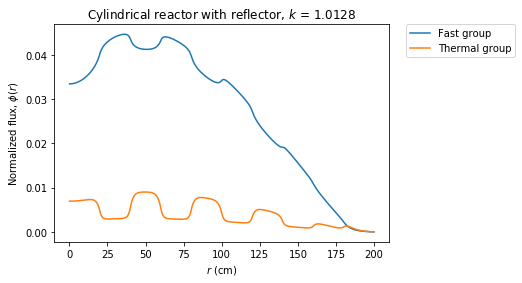

The power peaking factor is 1.6048


In [6]:
# Plot with reflector
plt.plot(rR,phi1R,label='Fast group')
plt.plot(rR,phi2R,label='Thermal group')
plt.title('Cylindrical reactor with reflector, $k$ = ' + str(kR)[0:6])
plt.xlabel('$r$ (cm)')
plt.ylabel('Normalized flux, $\phi(r)$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Define scalar flux and PPF
phiR = phi1R + phi2R
phiAvgR = np.average(phiR)
phiMaxR = phiR.max()
PPFR = phiMaxR/phiAvgR
print('The power peaking factor is', '%.4f' % PPFR)

$\br$Notice how there is a local thermal flux maximum within the fuel rods where there is a lack of moderator, and a local thermal flux minimum in the moderated regions. At the right edge, the fast flux smoothes out as a result of the reflector.

The $\texttt{regions}$ variable is then modified to account for the replacement of moderator with fuel at the right edge.$\br$

In [ ]:
# Solve without reflector
regions = ['Ur','M','U','M','U','M','U','M','U','U','U']
kU,phi1U,phi2U,rU = TwoGroupDiffusionEigenvalue(R,I,D_1,D_2,Sig_r_1,Sig_r_2,
                                                v_Sig_f_1,v_Sig_f_2,Sig_s12,1)

# Plot without reflector
plt.plot(rU,phi1U,label='Fast group')
plt.plot(rU,phi2U,label='Thermal group')
plt.title('Cylindrical reactor without reflector, $k$ = ' + str(kU)[0:6])
plt.xlabel('$r$ (cm)')
plt.ylabel('Normalized flux, $\phi(r)$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Define scalar flux and PPF
phiU = phi1U + phi2U
phiAvgU = np.average(phiU)
phiMaxU = phiU.max()
PPFU = phiMaxU/phiAvgU
print('The power peaking factor is', '%.4f' % PPFU)

Note how at the right edge, the flux no longer decreases in a smooth fashion. It instead drops linearly as a result of the removal of the reflector. The eigenvalue increases only slightly as a result of the removal of the reflector.